# Particle filtering for inference

Here, we try to put it all together to infer $\mathbf{v}$ from data.

In [1]:
import numpy as np
np.random.seed(12345)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': '\\usepackage{amsmath}\\usepackage{amssymb}'
})

import scipy.stats as stats

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.random as jr
import jax.numpy as jnp
from jax import jit, vmap
from jax.scipy.special import logsumexp

init_key = jr.key(123)

## Make some synthetic data

(copied over from `gen_synthetic_data.ipynb`)

In [2]:
max_freq = 250  # maximum (absolute value) frequency we care about
Nlat = 3  # number of latent patterns
N = 1000  # number of samples
dt = 0.001  # sample spacing (in s)

taxis = np.arange(0, N * dt, dt)
freqs = np.fft.fftshift(np.fft.fftfreq(N, dt))
Omega = freqs.shape[0]

In [3]:
center_freqs = [5, 25, 60]  # peak power frequencies of each latent
center_std = [.1, .5, 1.5]

all_v = []
for mu, sig in zip(center_freqs, center_std):
    right = stats.norm.pdf(freqs, loc=mu, scale=sig)
    left = stats.norm.pdf(freqs, loc=-mu, scale=sig)
    this_v = right + left
    this_v /= np.linalg.norm(this_v)
    all_v.append(this_v)

v = np.stack(all_v, axis=0)

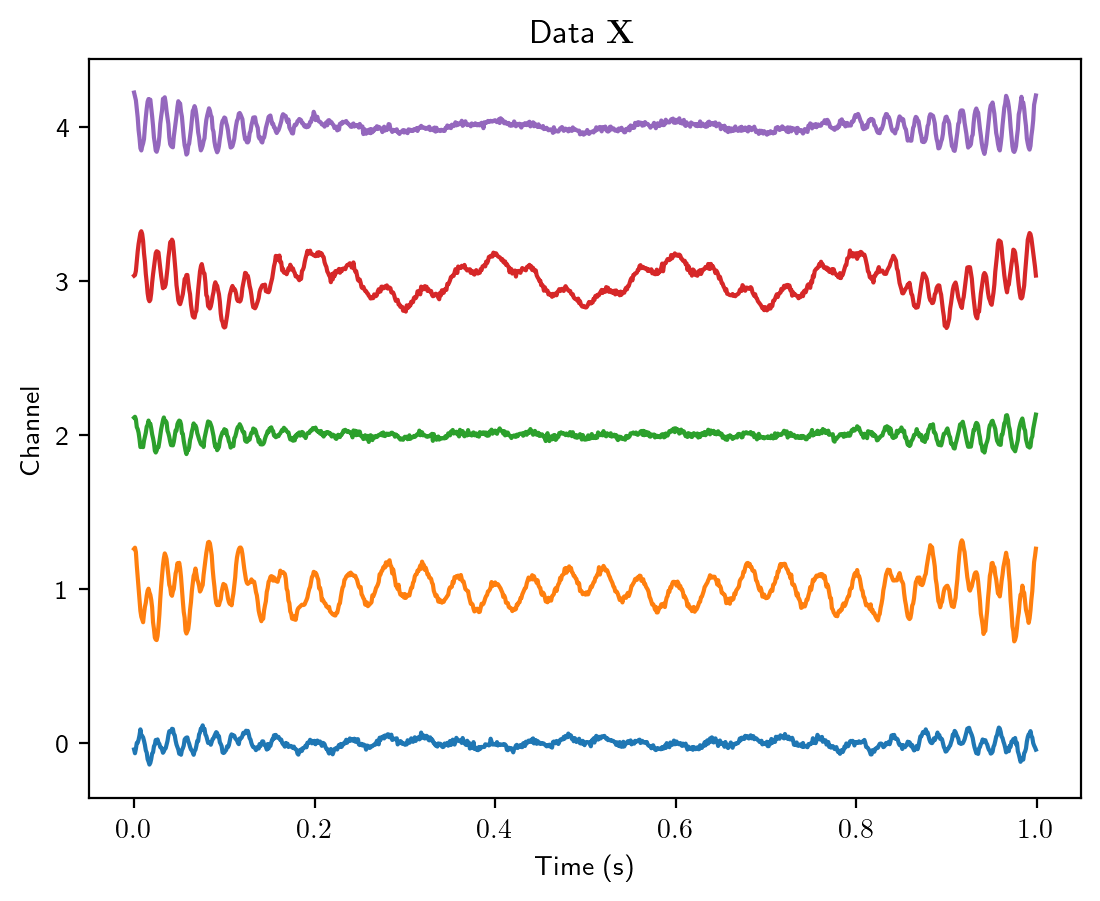

In [4]:
vv = np.fft.ifftshift(v, axes=1)
s = np.fft.ifft(vv)
s = np.real(s)  # real parts should be very near 0

# make D
Nchan = 5
D = np.random.randn(Nchan, Nlat)
D /= np.linalg.norm(D, axis=0)

# make x
eps = 1e-4
x = D @ s
x += eps * np.random.randn(*x.shape)

# plot it
scale_factor = 0.01
plt.plot(taxis, (x + scale_factor * np.arange(Nchan)[:, np.newaxis]).T);
plt.title(r"Data $\mathbf{X}$")
plt.xlabel("Time (s)")
plt.ylabel("Channel")
plt.gca().set_yticks(scale_factor * np.arange(Nchan));
plt.gca().set_yticklabels(range(Nchan));

## Define some functions for inference

(copied over from `v_sampling.ipynb`)

In [5]:
def phi(t, freqs):
    """
    Calculate phi_t as in notes. 
    Assumes \omega = 0 is at index 0!
    """
    phase = np.exp(1j * 2 * np.pi * freqs * t)
    phase[0] -= 1
    phase /= np.sqrt(freqs.shape[0] - 1)
    return phase

In [6]:
def vhat(vprev, bt, t, Omega, dt):
    """
    vprev = v_{t-1}
    bt    = \hat{m}_t/f_t
    t     = time
    Omega = number of frequencies
    """
    freqs = np.fft.fftfreq(Omega, dt)
    phit = phi(t, freqs)
    alpha = np.dot(vprev, phit)
    oo = Omega/np.sqrt(Omega - 1)
    lam = -np.conj(alpha) + oo * bt * np.sqrt((1 - np.abs(alpha)**2)/(1 - (oo * bt)**2))
    
    vv = (vprev + np.conj(lam * phit))/np.sqrt(1 + np.abs(lam)**2 + 2 * np.real(lam * alpha))
    
    return vv

In [7]:
def vMF_real2cplx(v):
    """
    Transform a N-vector draw from a vMF into v with 
    v^*{-omega} = v_{omega} (i.e., spectrum of a real signal).
    Assumes frequency 0 is also index 0!!!
    """
    vv = np.empty(v.shape, dtype=np.complex128)
    N = v.shape[0]
    mid = (N + 1)//2
    
    if N % 2 == 0:
        vv[:mid] = v[:mid]
        # vv[1:mid] += 1j * v[-1:mid:-1]
        # vv[0] += 1j * v[mid]
        vv[:mid] += 1j * v[mid:]
        vv[-1:mid:-1] = np.conj(vv[1:mid])
        vv[mid] = np.conj(vv[0])
    else:
        vv[:mid] = v[:mid]
        # vv[1:mid] += 1j * v[-1:(mid-1):-1]
        vv[1:mid] += 1j * v[mid:]
        vv[-1:(mid - 1):-1] = np.conj(vv[1:mid])
        
    return vv/np.sqrt(2)

In [8]:
def vMF_cplx2real(v):
    """
    Transform a N-vector complex spectrum v with 
    v^*{-omega} = v_{omega} (i.e., spectrum of a real signal)
    to a real vector with real parts up front and imaginary parts in back.
    Assumes frequency 0 is also index 0!!!
    """
    vv = np.empty(v.shape, dtype=np.float64)
    N = v.shape[0]
    mid = (N + 1)//2

    if N % 2 == 0:
        vv[:mid] = np.real(v[:mid])
        vv[mid:] = np.imag(v[:mid])
    else:
        vv[:mid] = np.real(v[:mid])
        vv[mid:] = np.imag(v[1:mid])
    return vv * np.sqrt(2)

## Set up inference

Calculate some quantities that we'll need later.

In the notes, we want to solve $\min \lVert \mathbf{X} - \mathbf{DM}\rVert_F$ for $\mathbf{M}$:

In [9]:
D.shape, x.shape

((5, 3), (5, 1000))

In [10]:
M = np.linalg.lstsq(D, x)[0]
M.shape

(3, 1000)

In [11]:
oo = Omega / np.sqrt(Omega - 1)

In the data above, we have assumed $f_{jt} = 1$, so we won't worry about that.

## Do particle filtering

The goal is not to make it fast, just to test for whether we can recover $\mathbf{v}$.

In [12]:
K = 10  # number of particles

In [13]:
# calculate initial guess for v
# assume "previous" v is white noise
vprev = np.ones(Omega)
vprev /= np.linalg.norm(vprev)
vprev = vMF_real2cplx(vprev)
vprev[0] = 0  # no zero-frequency

vhat0 = np.array([vhat(vprev, bt, 0, Omega, dt) for bt in M[:, 0]])

In [14]:
# sample initial v based on this guess
key, sample_key = jr.split(init_key)
mu = np.array([vMF_cplx2real(vv) for vv in vhat0])
mu /= jnp.linalg.norm(mu, axis=-1)[:, np.newaxis]
kappa = jnp.array(10. * Omega)  # uniform distribution
vmf = tfd.VonMisesFisher(mu, kappa)
vmf0 = vmf.sample((K,), sample_key)

# convert particle samples back to complex spectra
v0 = np.empty(vmf0.shape, dtype='complex128')
for k in range(vmf0.shape[0]):
    for l in range(vmf0.shape[1]):
        v0[k, l] = vMF_real2cplx(vmf0[k, l])

# calculate data
s0 = np.fft.ifft(v0)
s0 = np.real(s0)
xbar = (D @ s0)[:, :, 0]  # only want time 0

# calculate weights


We want to calculate weights. Initially:
$$
\log \tilde{w}_j = \log \mu(\mathbf{V}_j) + \log g(\mathbf{x}_0|\mathbf{V}_j) - \log q(\mathbf{V}_j|\mathbf{x}_0)
$$
where the terms are the prior, emission, and proposal distribution, respectively, and $\mathbf{V}_j$ is the $j$th particle sample of $\mathbf{v}$ at $t=0$.

In [15]:
# term 1: prior
# assume our prior is determined by mu = vprev above and kappa = 0 (uniform)
prior = tfd.VonMisesFisher(np.outer(np.ones(Nlat), vMF_cplx2real(vprev)).astype('float32'), 0.)
logw = prior.log_prob(v0).sum(axis=-1)

# term 2: emission
# assume multivariate normal with mean xbar and std eps
emissions = tfd.Normal(xbar.astype('float32'), eps)
logw += emissions.log_prob(x[:, 0]).sum(axis=-1)

# term 3: proposal
# as above, distribution is vMF(mu, kappa)
logw -= vmf.log_prob(vmf0).sum(axis=-1)

# normalize
logw -= logsumexp(logw)

Now we need to implement resampling:

In [16]:
def resample(logw):
    """
    Given a set of logged weights, return a set of indices corresponding to particles 
    from which the resampled weights are drawn. That is, if X are the samples, then
    X[resample(logw)] are the new particles, each with weight 1/len(logw).
    This implements Systematic Resampling as detailed in the Doucet review.
    """
    K = len(logw)
    # make a log cdf
    aa = np.tile(logw, (len(logw), 1))
    aa[np.triu_indices(K)] = -np.inf
    log_cdf = logsumexp(aa, 1)

    U = (np.arange(1, K + 1) - 1)/K
    U += np.random.rand()/K

    return np.digitize(np.log(U), log_cdf)

In [17]:
inds = resample(logw)
v0 = v0[inds]
logw = -np.log(K) * np.ones(K)